In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [3]:
# connect mysql
import pymysql
conn = pymysql.connect(host = 'localhost', user='dongyeon0317', password='1Q2w3e4r!@', db='crime_prediction', charset = 'utf8')
curs = conn.cursor(pymysql.cursors.DictCursor)

In [4]:
# select from Dataset - Choose scenario

# Season
num = int(input('1.Spring 2.Summer 3.Fall 4.Winter '))
if num == 1: season = 'Spring'
elif num == 2: season = "Summer" 
elif num == 3: season = "Fall" 
else: season = "Winter"

# Time    
num = int(input("1.Morning 2.Afternoon 3.Evening 4.Midnight "))
if num == 1: time = "Morning"  
elif num == 2: time = "Afternoon" 
elif num == 3: time = "Evening" 
else: time = "Midnight"
    
# Weather    
num = int(input("1.눈/비 2.맑음 3.흐림 "))
if num == 1: 
    where = 'WHERE (season = \''+ season + '\' and time = \'' + time + '\' and rainfall > 0) or (season = \'' + season + '\' and time = \'' + time + '\' and snowfall > 0);' 
elif num == 2: 
    where = 'WHERE (season = \''+ season + '\' and time = \'' + time + '\' and rainfall = 0 and cloud < 5) or (season = \'' + season + '\' and time = \'' + time + '\' and snowfall = 0 and cloud < 5);' 
else: 
    where = 'WHERE (season = \''+ season + '\' and time = \'' + time + '\' and rainfall = 0 and cloud >= 5) or (season = \'' + season + '\' and time = \'' + time + '\' and snowfall = 0 and cloud >= 5);' 

dataset_sql = 'SELECT grid, CCTV_num, police_value, resident, floating, Adult, Apartment, Commercial, Detached, School, Traffic FROM Dataset ' + where
grid_sql = 'SELECT grid, CCTV_num, police_value, resident, floating, Adult, Apartment, Commercial, Detached, School, Traffic FROM Grid WHERE time = \''+ time + '\''
curs.execute(dataset_sql)
dataset_result = curs.fetchall()
curs.execute(grid_sql)
grid_result = curs.fetchall()

1.Spring 2.Summer 3.Fall 4.Winter 2
1.Morning 2.Afternoon 3.Evening 4.Midnight 2
1.눈/비 2.맑음 3.흐림 2


In [5]:
# Transform to Pandas Dataframe
import pandas as pd
dataset_result = pd.DataFrame(dataset_result)
grid_result = pd.DataFrame(grid_result)
result = pd.concat([dataset_result, grid_result])
result['crime_num'] = result.groupby(['grid']).grid.transform('count') -1
result = result.drop_duplicates()
result = result.sort_values('grid')
result

,grid,CCTV_num,police_value,resident,floating,Adult,Apartment,Commercial,Detached,School,Traffic,crime_num
115,0,0,0,20,560,0,0,0,0,0,0,1
1,1,0,0,30,500,0,21,0,0,0,0,0
2,2,0,0,20,440,0,0,0,0,0,0,0
3,3,0,0,20,550,0,0,0,0,0,0,0
229,4,0,0,40,510,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1102,1102,8,0,310,4940,0,17,0,26,0,0,0
361,1103,0,0,330,4870,0,0,0,0,0,0,3
319,1104,0,0,450,5330,0,0,0,0,0,0,3
279,1105,0,0,240,5250,0,0,0,0,0,0,1


In [6]:
target = result['crime_num']
dataset = result.drop(columns=['grid'])

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_labels = train_dataset.pop('crime_num')
test_labels = test_dataset.pop('crime_num')

In [9]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CCTV_num,886.0,1.986456,3.083368,0.0,0.0,0.0,3.0,23.0
police_value,886.0,0.471783,0.848258,0.0,0.0,0.0,1.0,4.0
resident,886.0,111.952596,114.558953,0.0,30.0,50.0,210.0,480.0
floating,886.0,1787.223476,1769.225618,80.0,510.0,810.0,3655.0,5530.0
Adult,886.0,0.060948,0.290546,0.0,0.0,0.0,0.0,3.0
Apartment,886.0,36.822799,240.881599,0.0,0.0,0.0,3.0,5192.0
Commercial,886.0,34.836343,262.665075,0.0,0.0,0.0,0.0,4587.0
Detached,886.0,7.941309,13.698651,0.0,0.0,2.0,11.0,123.0
School,886.0,0.039503,0.241505,0.0,0.0,0.0,0.0,3.0
Traffic,886.0,0.145598,0.542247,0.0,0.0,0.0,0.0,6.0


In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_test_data

,CCTV_num,police_value,resident,floating,Adult,Apartment,Commercial,Detached,School,Traffic
53,-0.644249,-0.556179,-0.628084,-0.659737,-0.209771,-0.152867,-0.132626,-0.287715,-0.163572,-0.268509
84,-0.644249,2.980480,-0.802666,-0.761476,-0.209771,-0.152867,-0.132626,-0.579715,-0.163572,-0.268509
98,-0.644249,1.801594,-0.977249,-0.721911,-0.209771,-0.152867,-0.132626,-0.579715,-0.163572,-0.268509
99,0.004393,1.801594,-0.628084,-0.738868,-0.209771,-0.152867,-0.132626,-0.579715,-0.163572,-0.268509
166,-0.644249,-0.556179,-0.802666,-0.456258,-0.209771,-0.152867,-0.132626,-0.433715,-0.163572,-0.268509
...,...,...,...,...,...,...,...,...,...,...
462,-0.644249,-0.556179,1.466908,1.945923,-0.209771,-0.152867,-0.132626,-0.579715,-0.163572,-0.268509
349,-0.644249,-0.556179,1.816073,1.883749,-0.209771,-0.152867,-0.132626,0.150284,-0.163572,-0.268509
324,3.896240,-0.556179,1.379616,1.968532,-0.209771,0.137732,-0.132626,1.610282,-0.163572,-0.268509
1085,-0.644249,-0.556179,1.292325,0.770267,-0.209771,-0.152867,-0.132626,-0.579715,-0.163572,-0.268509


In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.02396655],
       [-0.08541606],
       [ 0.15944737],
       [-0.03815487],
       [ 0.4079309 ],
       [ 0.13457122],
       [ 0.03293555],
       [-0.04848407],
       [-0.12286358],
       [-0.19110638]], dtype=float32)

In [14]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,0.133223,0.188116,0.133223,1.334931,0.873120,1.334931,9995
9996,0.128181,0.183266,0.128181,1.376213,0.889925,1.376213,9996
9997,0.131184,0.188174,0.131184,1.325201,0.866241,1.325201,9997
9998,0.131087,0.186204,0.131087,1.309921,0.853080,1.309921,9998
9999,0.130956,0.185249,0.130956,1.291998,0.866984,1.291998,9999


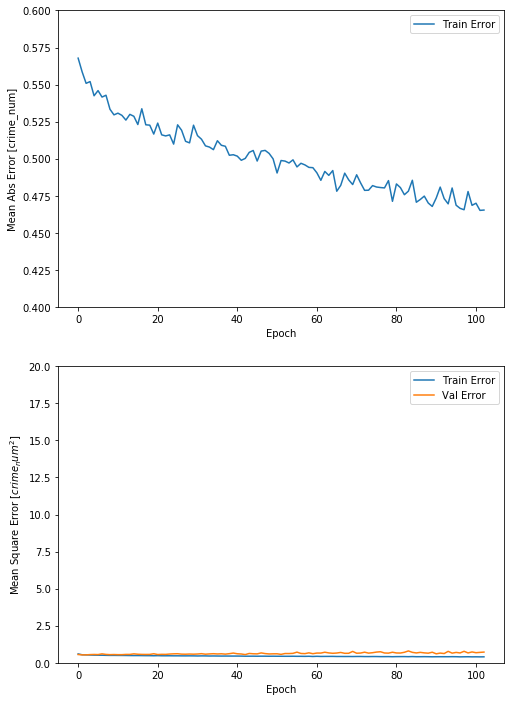

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [crime_num]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.ylim([0.4,0.6])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$crime_num^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................................
...

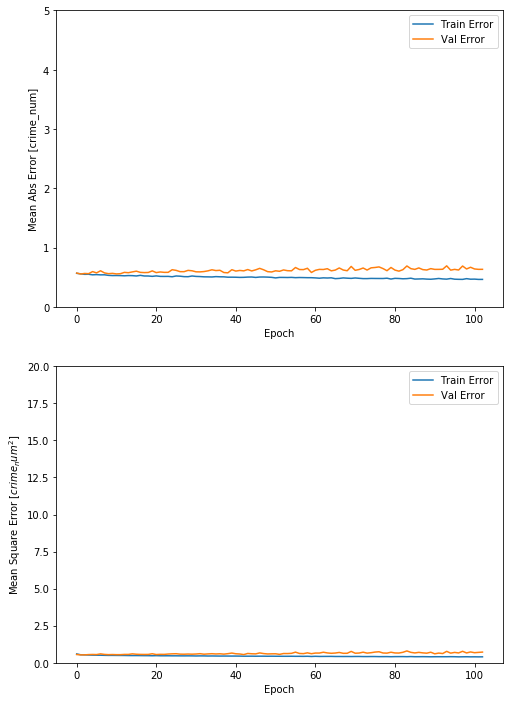

In [17]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

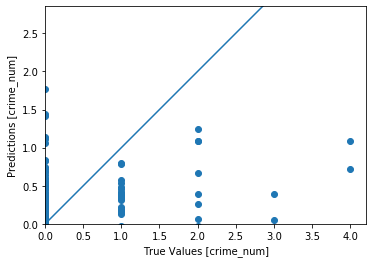

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [crime_num]')
plt.ylabel('Predictions [crime_num]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

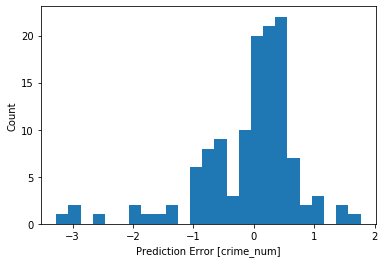

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [crime_num]")
_ = plt.ylabel("Count")

In [20]:
d = dataset.drop(columns=['crime_num'])
pred = model.predict(norm(d))

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
confusion_matrix = confusion_matrix(target, pred)

target_unique = np.unique(target)
confusion_df = pd.DataFrame(index=range(0), columns=['value', 'True', 'False'])

for i in range(len(target_unique)):
    true = 0
    false = 0
    for j in range(len(target_unique)):
        if abs(j - i) < 3:
            true += confusion_matrix[i][j]
        else:
            false += confusion_matrix[i][j]
            
    row = [target_unique[i], true, false]
    confusion_df = confusion_df.append(pd.Series(row, index=confusion_df.columns), ignore_index=True)
    
true_total = confusion_df['True'].sum()
false_total = confusion_df['False'].sum()

print("정확도 : " + str(true_total / (true_total + false_total)))
 
confusion_df

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets